# Lab 2: Comparing Means
## w203 Statistics for Data Science

Student Names: Kevin Hartman and Francis Leung

Section Number: 5

In [1]:
A = read.csv("anes_pilot_2018.csv")

In [2]:
library(survey)
library(effsize)
library(dplyr)
library(ggplot2)
library(tableone)

ERROR: Error in library(survey): there is no package called ‘survey’


We will use the survey package to apply weights to our sample. Why apply weights?

Raw survey data tends to underpresent certain groups that weren't collected in the study. For example, in the US population we know there are roughly 49.2% men and 50.8% women, and we know that 9.9% of the population makes up the age group from 18-24, and we know certain percentages of the population are black, hispanic, white, etc. 
[Can we put a source here?] 

We can alter the weights of different groups in the sample to make it more reflective of the population: e.g. increasing the weight of under-represented popuplations and lowering that of the over-represented. This process is called raking. ANES provides the weight vector as a result of conducting the rake process over the data set.

## Question 1: Do US voters have more respect for the police or for journalists?

### Introduce your topic briefly.  (5 points)
Explain how your variables are operationalized.  Comment on any gaps that you can identify between your operational definitions and the concepts you are trying to study.

>From a conceptual standpoint we want to understand how US voters feel about police or journalists as a measure of respect, and determine which group, if there is a difference, where respect may be strongest.
>
>*Feeling Thermometers:* We have two  questions from the survey that ask the survey respondent to rate their sentiment toward police and journalists on a  scale of 0-100
>
>* **ftpolice**: How would you rate the police?
>* **ftjournal**: How would you rate journalists?
>
>This rating is not explicitly a measure of respect, but by virtue of the response representing an overall favorability measurement, respect can be inferred, e.g. people tend to show respect for things in which they favor and demonstrate lack of respect for things they don't. One limitation for our extrapolation is that "rate" could be open to different interpretations by different respondents. We don't know that if respondents are rating police and journalists based on their effectiveness, contribution to society, as professions or by any other metric.
>
>We also note that although these variables are recorded on a sliding continium, we recognize them as ordinal in nature. They are not precise measurements as in a real thermometer. Your score of 80 may be my score of 65. However, given my rating of 65 and yours of 85 you and I will be consistent across questions using our personal methodogy. And since we are comparing feeling scores across measures there will be consistency in our  comparative ranking placement when we compare results.
>
>*Registered Voters*: We also have a question on the survey indicating whether the interviewer is registered to vote. 
>
>* **reg**: Are you registered to vote, or not?
>
>This is important as we are asking the question "Do US voters have..." and will be making comparisons on feeling thermometers for just US voters.
>

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)
This should include a treatment of non-response and other special codes, basic sanity checks, and a justification for any values that are removed.  Use visual tools to assess the relationship among your variables and comment on any features you find.

In [3]:
#General recodes
#Recode the inputstate based on the errata https://electionstudies.org/2018-pilot-study-updates-errata/
A$inputstate[A$inputstate==-1] <-9
A$inputstate[A$inputstate==-7] <-8
#Recode all Don't Know (DK) answers to NA
A[A==-7] <- NA
#Recode all legitimate skips to NA
A[A==-1] <- NA

In [4]:
#ftpolice and ftjournal are the thermometer readings.
#Difference variable is so that the means can be compared for testing
A$diff_police_journalist_ftemp<-A$ftpolice - A$ftjournal

In [5]:
#Removing errors in collection from excedingly large
#thermometer readings since > 100 is not a valid response
A[A==997] <- NA

In [6]:
#Create a survey design from our data
anes_design = svydesign(ids = ~1, data=A, weights = ~weight)

#Include the relevent questions in our design object for analysis preparation
anes_design <- 
    update( 
        anes_design ,     
        one = 1,
        police_ftemp = ifelse( ftpolice %in% 0:100 , ftpolice , NA ) ,
        journalist_ftemp = ifelse( ftjournal %in% 0:100, ftjournal , NA ) ,
        registered_voter = ifelse( reg %in% 1:3 , as.numeric( reg %in% 1:2 ) , NA ) ,
        voter_police_ftemp = ifelse(registered_voter == 1, police_ftemp, NA),
        voter_journalist_ftemp = ifelse(registered_voter == 1 , journalist_ftemp, NA),
        diff_voter_police_journalist_ftemp = ifelse(registered_voter ==1, diff_police_journalist_ftemp, NA)
)


ERROR: Error in svydesign(ids = ~1, data = A, weights = ~weight): could not find function "svydesign"


Let's review the histogram from the two thermometer readings. These histograms will be weighted to represent the population because we're pulling the values out from the survey design package. See svytable.

In [7]:
dfpolice <- svytable(~voter_police_ftemp, anes_design ) %>% as.data.frame() %>% mutate(Prop = Freq/sum(Freq))
dfjournalist <- svytable(~voter_journalist_ftemp, anes_design ) %>% as.data.frame() %>% mutate(Prop = Freq/sum(Freq))
dfp<-data.frame(ftemp=as.numeric(dfpolice$voter_police_ftemp)-1, tempFreq=dfpolice$Freq, prop=dfpolice$Prop)
dfj<-data.frame(ftemp=as.numeric(dfjournalist$voter_journalist_ftemp)-1, tempFreq=dfjournalist$Freq, prop=dfjournalist$Prop)
dfp$category<-'police'
dfj$category<-'journalists'
dfvotertherm<-rbind(dfp,dfj)

ERROR: Error in svytable(~voter_police_ftemp, anes_design) %>% as.data.frame() %>% : could not find function "%>%"


In [8]:
ggplot(dfvotertherm, aes(x = ftemp, weight=tempFreq, color=category, fill = category)) + 
  geom_histogram(position="identity", alpha=0.5, bins=30) +
  labs(title="Weighted Thermometer Readings for Registered Voters", x="Temperature", y="Number of Voters")

ERROR: Error in ggplot(dfvotertherm, aes(x = ftemp, weight = tempFreq, color = category, : could not find function "ggplot"


Notably, there is a higher concentration of lower temperature readings for journalists than there are for police in the histogram above.

We will also review the boxplots of the same two thermometers to confirm this rationale.

Note where the means fall relative to one another in the boxplot below, with the one for police higher than that for journalists.

In [9]:
ggplot(dfvotertherm, aes(x = prop, y=ftemp, weight=tempFreq, fill = category)) + 
  geom_boxplot(position="identity", alpha=0.5) +
 labs(title="Thermometer Readings for Registered Voters", x="Proportion of Responses", y="Temperature")

ERROR: Error in ggplot(dfvotertherm, aes(x = prop, y = ftemp, weight = tempFreq, : could not find function "ggplot"


### Based on your EDA, select an appropriate hypothesis test.  (5 points)
Explain why your test is the most appropriate choice, focusing on its statistical assumptions.

>Because the measures are ordinal, and because both measures are from the same sample, we will apply a non-parametic Wilcoxon Signed Rank test to compare means.
>
> The null hypothesis is
> * $H_0: \mu_{police} = \mu_{journalists}$, there is no difference in favor for police and journalists. 
>
> The alternative hypothesis is
> * $H_A: \mu_{police} \neq \mu_{journalists}$, there is a difference in favor for police and journalists.

### Conduct your test. (5 points)
Explain (1) the statistical significance of your result, and (2) the practical significance of your result.  Make sure you relate your findings to the original research question.

>We would like to apply the survey design's Wilcoxon test for weights, however, the design package has a limitation in comparing paired measures from the same sample. The syntax of the call would appear as follows, but execution of the code generates an error.

In [10]:
svyranktest(diff_voter_police_journalist_ftemp~one, anes_design, na.rm=TRUE, test="wilcoxon")

ERROR: Error in svyranktest(diff_voter_police_journalist_ftemp ~ one, anes_design, : could not find function "svyranktest"


>Instead, we will run the test outside of the survey design package. Unfortunately this means weights will not be accounted for in this particular test. Implementing a weighted verson of the Wilcoxon Signed Rank Test algorithm is outside the scope of this lab excercise.

In [11]:
# prepare a vector of responses from registered voters
v_police=A$ftpolice * as.numeric( A$reg %in% 1:2 ) 
v_police[v_police==0]<-NA
v_journalists=A$ftjournal * as.numeric( A$reg %in% 1:2 ) 
v_journalists[v_journalists==0]<-NA 

wilcox.test(v_police,
            v_journalists,
            paired=TRUE, conf.int=TRUE)



	Wilcoxon signed rank test with continuity correction

data:  v_police and v_journalists
V = 1113900, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
  8.99993 13.99997
sample estimates:
(pseudo)median 
      11.49992 


In [12]:
tab<-svymean(~voter_police_ftemp, anes_design, na.rm=TRUE)
tab

ERROR: Error in svymean(~voter_police_ftemp, anes_design, na.rm = TRUE): could not find function "svymean"


>We also want to review the statistic's effect size. Effect size for a Wilcoxon Signed-rank test is defined as
>$$r = \frac{Z}{\sqrt{N}}$$
>
>The standard wilcox test does not return the Z value, but the coin package includes a version of the wilcoxon Signed Rank Test that does.

In [13]:
library(coin)

ERROR: Error in library(coin): there is no package called ‘coin’


In [14]:
wilcoxsign_test(v_police~v_journalists)

ERROR: Error in wilcoxsign_test(v_police ~ v_journalists): could not find function "wilcoxsign_test"


In [15]:
r<-9.2278/sqrt(2500)
r

[1] 0.184556

>**Q1 Summary of Results:**
>
>From the very small p-value obtained (2.2e-16), we can reject the null hypothesis and accept the alternative that there is a difference in favor.
>
>In fact, after inspection of the means from each measure, and from the boxplot in the EDA above, we can suggest that in general voters have a higher opinion of police than they do of journalists.
>
>Thus, our test shows that there is statistical significance but little practical significance.

## Question 2: Are Republican voters older or younger than Democratic voters?

### Introduce your topic briefly.  (5 points)
Explain how your variables are operationalized.  Comment on any gaps that you can identify between your operational definitions and the concepts you are trying to study.

>We would like to compare the average age of Republican voters against the average age of Democratic voters. In order to do so, we need to determine 1) the age of the voter and 2) the political affiliation of the voter. We attempt to operationalize our variables as follows:
>
>*Age of Voter:*
An examination of the ANES questionnaire specification indicates that there is a field called 'birthyr' that corresponds to the question 'In what year were you born?' Given that this study was conducted in December 2018, we can calculate a new variable called age by subtracting 'birthyr' from 2018. 
>
>* Given that the survey was completed before Dec 21, 2018, there is a slight possibility that certain values for "age" may be off by a year as the participant could have been born in the remaining 10 days of the year. However, this is should not be an important distinction. 
>* We can sanity check this age variable in our EDA by looking at its range. We should expect that that the minimum age is 18 given that survey participants should be 18 or older.
>
>*Party Affiliation:*
What does it mean to be a "Republican" or "Democrat" voter? Does it depend on a voter's previous voting record? Or perhaps on party registration? Or how they describe their own political affiliation? 
>
>* Self-described political affiliation: We believe that the self-described political affiliation, in the fields pid1d or pid1r is the best variable to use to determine with which party the voter best identifies. These fields correspond with the survey question "Generally speaking, do you usually think of yourself as a Democrat, a Republican, an
independent, or what?" However, just because the voter identifies with one party (or neither) at the time the survey was conducted in 2018 does not mean that they have always identified with this choice. Also, as political parties (and what they stand for) evolve over time, we must be careful when extrapolating this classification across time periods. We may also miss voters who declare themselves as others, but still feel like they are either "More democrat " or "more Repbulican". Nonetheless for the avoidance of doubt, a "Republican" voter in our study will be defined as someone who identified as "Generally speaking, thinking of themselves as a Republican in December 2018," and likewise for a Democrat voter. 
>
>We also examined other ways to determine the political affiliation of a voter, but found them to be more ambigious and less optimal operationalizations of our variables. 
>
>* Voting record: Entries such as 'vote16' which corresponds to the voter's choice in the 2016 presidential election, or other fields related to the 2018 elections could give us insight into each voter's record. However, just because a voter voted for a democratic candidate in 2016 or 2018 does not provide enough data points to determine them as a "democrat" voter, and we may run into difficult judgement calls if the voter voted for different parties in the two years. 
>
>* Voter registration: The field 'vote20dem' offers us insight into whether a voter planned to participate in the 2020 democratic primaries. Primaries in the US are only open to registered voters of that party. This would give us insight into which voters have registered as Democrats, but would not give us insights into those who did not (if they are Republican, indpendent or something else).

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)
This should include a treatment of non-response and other special codes, basic sanity checks, and a justification for any values that are removed.  Use visual tools to assess the relationship among your variables and comment on any features you find.

>**Age**
>* As defined above, we compute age by subtracting birthyr from 2018.
>* We note from the summary and histogram below that the range of all ages are from 18 - 91 years old, with the mean age of all survey participants as 49.5 years.
>* We note that most respondents are between 20-70 years, with fewer >80. This makes sense as overall in the US population there should be less people alive and computer literate >80.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   35.00   52.00   49.48   62.00   91.00 

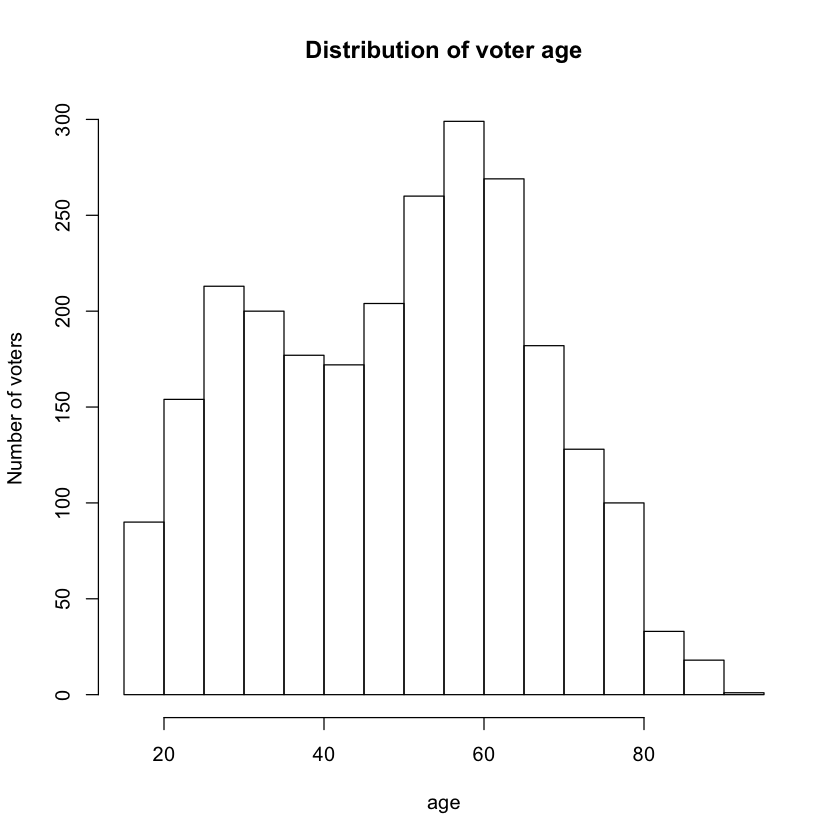

In [16]:
age<- 2018-A$birthyr
summary(age)
hist(age, main="Distribution of voter age", ylab="Number of voters")

>**Political Affiliation**
>* Since this question had two formats, which ranked either "Democrat" or "Republican" first, we need to look at book fields "pid1d" and "pid1r". 
> * Sanity checks: We checked to see that only one of either "pid1d" or "pid1r" was answered. We also note that these fields only contained the numbers (1-4) and NAs, as we have recoded the answers for skips. 

In [21]:
#Extract all the rows from A$pid1d that equal 1 (democrat) or 2 (republican)
# Extract relevant columns from A.
df_1d<-select(A,birthyr,pid1d)
# Add an age column.
df_1d$age<-2018-A$birthyr
# Replace 1 and 2 with democrat and republican, respectively.
df_1d$pid1d<-replace(df_1d$pid1d,A$pid1d==1,"democrat")
df_1d$pid1d<-replace(df_1d$pid1d,A$pid1d==2,"republican")
# Filter out all other values.
df_1d<-df_1d %>% filter(pid1d == "democrat" | pid1d=="republican")
#Rename pid1d to party.
df_1d<-rename(df_1d, party = pid1d)
# Drop birth year column.
df_1d<-select(df_1d, age,party)

In [22]:
#Extract all the rows from A$pid1r that equal 1 (republican) or 2 (democrat)
# Extract relevant columbns from A.
df_1r<-select(A,birthyr,pid1r)
# Add an age column.
df_1r$age<-2018-A$birthyr
# Replace 1 and 2 with democrat and republican, respectively.
df_1r$pid1r<-replace(df_1r$pid1r,A$pid1r==1,"republican")
df_1r$pid1r<-replace(df_1r$pid1r,A$pid1r==2,"democrat")
# Filter out all other values.
df_1r<-df_1r %>% filter(pid1r == "democrat" | pid1r=="republican")
#Rename pid1r to party.
df_1r<-rename(df_1r, party = pid1r)
# Drop birth year column.
df_1r<-select(df_1r, age,party)
# Combine both tables
age_df<-rbind(df_1d,df_1r)

In [23]:
rep<-filter(age_df,party=="republican")
dem<-filter(age_df,party=="democrat")

In [24]:
# Create a histogram.
ggplot(age_df, aes(x=age, color=party, fill=party)) +
  geom_histogram(position="identity", alpha=0.5, bins =40) + ggtitle("Voters by party affiliation")+ylab("Number of voters")

ERROR: Error in ggplot(age_df, aes(x = age, color = party, fill = party)): could not find function "ggplot"


### Based on your EDA, select an appropriate hypothesis test.  (5 points)
Explain why your test is the most appropriate choice, focusing on its statistical assumptions.

>We believe an indpendent T-test is the most appropriate choice because:
>
>* There are two categorical groups for our independent variable and the groups are different people.
>* Based on the histogram above, the dependent variable (age) is continuous. 
>* Both groups appear to be fairly normally distributed from the histogram above and the sample size for both are over 700, which means the CLT should hold.
>* The draws for both groups should be fairly independently and identically distributed given the YouGov sample methodology. It is not possible for a respondent to be in both groups.
>
>As a result, we will use an Independent Two Sample T-Test to determine if there is a statistically significant difference between the means in two unrelated groups. 
>* Our null hypothesis is $H_0: \mu_{republican} = \mu_{democrat}$ 
, There are no difference between the mean age of democrat and republican voters. 
>* The alternative hypothesis is $H_A: \mu_{republican} \neq \mu_{democrat}$ , The mean age of repbulican voters are greater or less than the mean of democrat voters. 
>


### Conduct your test. (5 points)
Explain (1) the statistical significance of your result, and (2) the practical significance of your result.  Make sure you relate your findings to the original research question.

In [ ]:
t.test(age ~ party, data=age_df)

In [ ]:
cohen.d(age~party, data=age_df)

>**Q2 Summary of Results:**
>
>Our paired T-test returned a p-value of 0.1941, which is greater than 0.05. As a result, our test is not statistically significant and we failed to reject the null hypothesis that there is no difference between the mean age of democrat voters and republican voters. 
>
>We also note from the t-test that the positive t-value indicates that the sample mean of the first group was higher than the sample mean of the second group (which we note to be true as the sample mean of the democrat group was 51.9 compared to 50.8 of the republican group). The 1463.4 degrees of freedom indicates that the sample variances between the two groups were not equal. Also, typically if the 95% CI includes 0, the results are not statistically significant, which is reflected in the p-value.
>
>Practically, using the Cohen's d method we got a d estimate of 0.068, which is less than 0.2. As a result, the practical significance of our test is small. 
>
>Thus from our analysis of this sample, while the mean age of Republican voters was different from the mean age of Democrat voters in our survey population, we can not conclude that the Republican voters are older or younger than Democrat voters. It is only through a very careful study can we see the effect of age on one's self-professed party affiliation, if there is an effect at all. 

**We will conduct a brief survey design version of this test for comparison. Note that the survey design will apply weights to the sample to reflect the population.**


In [ ]:
anes_design <- 
    update( 
        anes_design , 
        
        one = 1,
        
        age = as.numeric(2018 - birthyr),
        
        party_iden = case_when (
            (pid1d == 1 | pid1r == 1) & pidstr == 1 ~ 1, #Strong Democrat
            (pid1d == 1 | pid1r == 1) & (pidstr == 2 | pidstr == 0) ~ 2, #Not very strong Democrat
            (pid1d == 4 | pid1r == 4) & (pidlean == 2) ~ 3, #Something else, closer to Democrat
            (pid1d == 4 | pid1r == 4) & (pidlean == 1) ~ 7, #Something else, closer to Republican
            (pid1d == 2 | pid1r == 2) & (pidstr == 2 | pidstr == 0) ~ 8, #Not very strong Republican
            (pid1d == 2 | pid1r == 2) & pidstr == 1 ~ 9, #Strong Republican
            (pidlean == 2) ~ 4, #Indep, Closer to Democratic Party
            (pidlean == 3) | ((pid1d == 3 | pid1r == 3) & pidlean == 0) ~ 5, #Independent
            (pidlean == 1) ~ 6, #Indep, Closer to Republican Party
            TRUE ~ 0, 
        ),
        
        party_iden2 = ifelse( party_iden %in% 1:2,
                              1,
                              ifelse( party_iden %in% 8:9,
                                      2,
                                      NA)
                            ),

        party =
            factor( party_iden2 , levels = 1:2 , labels =
                c( 'Democrat',
                    'Republican')
            )  
)

In [ ]:
df<-svytable(~party+age, anes_design ) %>% as.data.frame() %>% mutate(Prop = Freq/sum(Freq))
df$age<-as.numeric(df$age)+17

In [ ]:
ggplot(df, aes(x = age, weight=Freq, color=party, fill = party)) + 
  geom_histogram(position="identity", alpha=0.5, bins=40) +
  labs(title="Voters by party affiliation - Weighted", x="Age", y="Number of Voters")

In [ ]:
svyby(~age, ~party, anes_design, svymean, na.rm=TRUE)

In [ ]:
svyttest(age ~ party, anes_design)

In the weighted version of our test using the survey design package we see that the average mean age is lower for Democrats vs Republicans, and, after running the t-test we see that that we would in fact reject the null that there is no difference between the average age of Democrats and Republicans.

This shows statistical significance.

A quick check on standard mean difference SMD (below) shows there is a moderate amount of practical significance.

In [ ]:
vars <- c("age")
strata<-c("party")
tabIPW <- svyCreateTableOne(vars = vars, strata=strata, 
                            testApprox="svyTTest", data = anes_design)
print(tabIPW, smd = TRUE)

## Question 3: Do a majority of independent voters believe that the federal investigations of Russian election interference are baseless?

### Introduce your topic briefly.  (5 points)
Explain how your variables are operationalized.  Comment on any gaps that you can identify between your operational definitions and the concepts you are trying to study.

>We would like to determine if a majority of independent voters believes the Russian election inteference are baseless. In order to do so, we need to determine 1) which voters identify as independent and 2) whether they believe that the investigations are baseless. We attempt to operationalize our variables as follows:
>
>*Affiliation as independent:*
>Similar to Question 2 above, we believe that the self-described political affiliation, in the fields 'pid1d' or 'pid1r' is the best variable to use to determine which voters identify as indpendents. The limitations of using this field are noted in Q2.
>
>*Majority:*
>We define majority as a simple majority, i.e. >50% # of independent voters.
>
>*Belief that federal investigations of Russian election inteference are baseless*
The federal investigations into Russian election inteference can be grouped into two buckets of investigations that were separately pursued by the US House of Representatives, Senate and Department of Justice: 1) Whether or not the Russians interfered in the 2016 presidential election, and 2) Whether there were links ir coordination between Donald Trump's campaign and the Russian government. 
>
>For the purpose of our investigation, we limit our examination of "federal investigations" to the first bucket. As a result, we are interested in the variable 'russia16' which corresponds to the question 'Do you think the Russian government probably interfered in the 2016 presidential election to try to help Donald Trump win, or do you think this probably did not happen? ' The answers for russia16 are either (1) for "Russia probably interfered" and (2) for "This probably did not happen." We will also operationalize this by changing the first response to 0 and the second to 1. 
>
>* One limitation of this operationalization is that while voters may hold the view that the Russians inteference probably did not occur, it does not necessarily mean that they think the investigation is baseless. They could in fact hold that the opinion that an investigation is necessary to confirm the Russians did not intefere. 

### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)
This should include a treatment of non-response and other special codes, basic sanity checks, and a justification for any values that are removed.  Use visual tools to assess the relationship among your variables and comment on any features you find.

>**Independent Political Affiliation**
>* We have already checked the pid1d and pid1r fields in Q2.
>* From the EDA below, we can see that there are 767 respondents that identified as independent.
>
>**Russian Election Inteference**
>* We should expect to see only answers 1,2, NA for 'russia16' before our transformation. 

In [18]:
# Validate values for Russia16
unique(A$russia16)

[1]  2  1 NA

In [20]:
#Extract all the rows from A$pid1d that equal 3 (independent)
# Extract relevant columbns from A.
df_ind1<-select(A,russia16,pid1d)
# Replace 3 with independent.
df_ind1$pid1d<-replace(df_ind1$pid1d,A$pid1d==3,"independent")
# Filter out all other values.
df_ind1<-df_ind1 %>% filter(pid1d == "independent")
#Rename pid1d to party.
df_ind1<-rename(df_ind1, party = pid1d)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



russia16,party
2,independent
2,independent
1,independent
1,independent
1,independent
1,independent


In [26]:
# Repeat for A$pid1r that equals 3(independent)
# Extract relevant columbns from A.
df_ind2<-select(A,russia16,pid1r)
# Replace 3 with independent.
df_ind2$pid1r<-replace(df_ind2$pid1r,A$pid1r==3,"independent")
# Filter out all other values.
df_ind2<-df_ind2 %>% filter(pid1r == "independent")
#Rename pid1r to party.
df_ind2<-rename(df_ind2, party = pid1r)

In [27]:
# Combine both tables
ind_rus_df<-rbind(df_ind1,df_ind2) 
# Adjust russia 16 to 0 for "Russia probably interfered" and 1 for "This probably did not happen.".
ind_rus_df$russia16<-replace(ind_rus_df$russia16, ind_rus_df$russia16==1,0)
ind_rus_df$russia16<-replace(ind_rus_df$russia16, ind_rus_df$russia16==2,1)
head(ind_rus_df)
print("Number of voters")
length(ind_rus_df$russia16)
print("Russia16 Unique values:")
unique(ind_rus_df$russia16)

russia16,party
1,independent
1,independent
0,independent
0,independent
0,independent
0,independent


[1] "Number of voters"


[1] 767

[1] "Russia16 Unique values:"


[1] 1 0

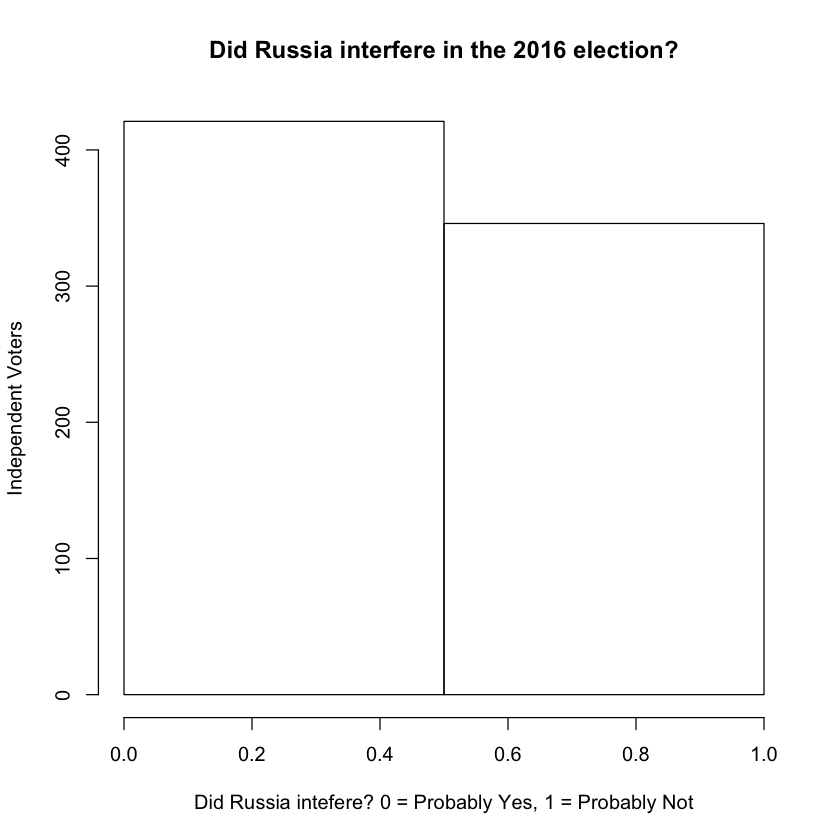

In [28]:
hist(ind_rus_df$russia16, breaks = 2, main = "Did Russia interfere in the 2016 election?", xlab="Did Russia intefere? 0 = Probably Yes, 1 = Probably Not", ylab="Independent Voters")

### Based on your EDA, select an appropriate hypothesis test.  (5 points)
Explain why your test is the most appropriate choice, focusing on its statistical assumptions.

>We believe an two-sided, one sample T-test is the most appropriate choice because:
>
>* We have a large sample size (767) entries and believe that the Central Limit Theorem should hold, so the distribution should resemble a semi-normal distribution.
>* The draws should be fairly independently and identically distributed given the YouGov sample methodology. It is not possible for a respondent to be in both groups.
>* Since the true mean can be greater, equal or less than 0.5, a two-tailed test is more appropriate than a one-tailed t-test. 
>
>However, since a two-sided t-test will not tell us if the true mean is >0.5, we will also construct a 95% confidence interval and examine the t-statistic to determine if the true mean is less than or greater than 0.5 in the case that the null hypothesis is rejected. 
>
>
>We will use a two tailed, one sample T-Test to determine if the majority of independent voters feel that the federal investigations into Russian election inteference are baseless.   
>* Our null hypothesis is $H_0: \mu = 0.5$ 
>* The alternative hypothesis is $H_A: \mu \neq 0.5$.



### Conduct your test. (5 points)
Explain (1) the statistical significance of your result, and (2) the practical significance of your result.  Make sure you relate your findings to the original research question.

In [29]:
t.test(ind_rus_df$russia16, mu=0.5)


	One Sample t-test

data:  ind_rus_df$russia16
t = -2.7194, df = 766, p-value = 0.006689
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.4158139 0.4864025
sample estimates:
mean of x 
0.4511082 


In [30]:
# Practical effect size using Cohen's d estimate:
(0.5-mean(ind_rus_df$russia16))/sd(ind_rus_df$russia16)

[1] 0.09819036

>**Q3 Summary of Results:**
>
>Our one sample T-test returned a p-value of 0.007, which is much less than 0.05. As a result, our test is statistically significant and we can reject the null hypothesis that the true mean is less than or equal to 0.5. Since our 95% CI is (0.415,0.486) and we have a negative t statistic with 766 degrees of freedom, we can reasonably conclude that the true mean is less than 0.5 since 95% of intervals constructed in this manner should contain the true mean. 
>
>Practically, using the Cohen's d method we got a d estimate of 0.09, which is less than 0.2. As a result, the practical significance of our test is small. 
>
>Given that we operationalized the belief that federal investigations of Russian election inteference are baseless based on whether or not respondents believed that the Russia intefered with the election, we determined that the majority of independent voters believe Russia probably did intervene and we extrapolate that to imply that they belief that the federal investigations have merit. However, this finding should be taken with a grain of salt as the practical significance is small. 

**We will conduct a breif survey design version of this test for comparison. Note that the survey design will apply weights to the sample to reflect the population.**

In [31]:
anes_design <- 
    update( 
        anes_design , 
        
        one = 1,
        
        party_iden = case_when (
            (pid1d == 1 | pid1r == 1) & pidstr == 1 ~ 1, #Strong Democrat
            (pid1d == 1 | pid1r == 1) & (pidstr == 2 | pidstr == 0) ~ 2, #Not very strong Democrat
            (pid1d == 4 | pid1r == 4) & (pidlean == 2) ~ 3, #Something else, closer to Democrat
            (pid1d == 4 | pid1r == 4) & (pidlean == 1) ~ 7, #Something else, closer to Republican
            (pid1d == 2 | pid1r == 2) & (pidstr == 2 | pidstr == 0) ~ 8, #Not very strong Republican
            (pid1d == 2 | pid1r == 2) & pidstr == 1 ~ 9, #Strong Republican
            (pidlean == 2) ~ 4, #Indep, Closer to Democratic Party
            (pidlean == 3) | ((pid1d == 3 | pid1r == 3) & pidlean == 0) ~ 5, #Independent
            (pidlean == 1) ~ 6, #Indep, Closer to Republican Party
            TRUE ~ 0, 
        ),
        
        independent = ifelse(party_iden %in% 4:6, as.numeric(party_iden %in% 4:6), NA),
        
        interfered =
            factor( russia16 , levels = 1:2 , labels =
                c( 'Yes',
                    'No')
            )
)

ERROR: Error in update(anes_design, one = 1, party_iden = case_when((pid1d == : object 'anes_design' not found


In [32]:
svyby(~interfered, ~independent, anes_design, svymean, na.rm=TRUE)

ERROR: Error in svyby(~interfered, ~independent, anes_design, svymean, na.rm = TRUE): could not find function "svyby"


In [33]:
svyttest(independent ~ interfered, anes_design, na.rm=TRUE)

ERROR: Error in svyttest(independent ~ interfered, anes_design, na.rm = TRUE): could not find function "svyttest"


By looking at the survey means after generalizing to the population we see there is near equilibrium in belief of interference amongst independent voters. And given the high p-values after the test, we would fail to accept the null.

## Question 4: Was anger or fear more effective at driving increases in voter turnout from 2016 to 2018?

### Introduce your topic briefly.  (5 points)
Explain how your variables are operationalized.  Comment on any gaps that you can identify between your operational definitions and the concepts you are trying to study.

>From a conceptual standpoint we want to understand levels of voter fear and anger in our current political climate as a measure of influence to turnout. While the question is interesting, we also can't discount other contributing factors to turnout, such as a controversial issue on the ballot like marijuana legalization.
>
>That said, we are looking specifically at anger over fear or fear over anger as a contributing factor, and assuming there will always be error terms, we wish to find information on which of these two variables played more of a factor.
>
>*Global Emotion Battery* We have four such questions from the survey that provide sentiment on anger and fear with respect to feeling about the way things are going in the country. There are also questions concerning anger and fear specific to Donald Trump and his actions in office. While anger and fear against Donald Trump may factor into increased turnout, it does so only on the Decratic side; The same logic would not apply to Republicans.
>
>Therefore, we will use the general sentiment "on the way things are going in the country" as the independent variables that may have contributed to turnout in 2018. 
>
>> * **geangry**: How do you feel about the way things are going in the country: angry
>* **geworried**: How do you feel about the way things are going in the country: afraid
>
>We note that these are ordinal values on a ranked scale.
>
>*Turnout* We will operationalize the meaning of the "increased turnout" sample to include those who voted in 2018 (vs those who did not vote). Those who voted in 2018 all contributed to a higher turnout. We do not need to compare voters in 2018 with 2016 to deduce this because we are not arguing whether increased turnout happened in this research, but taking it on face value that it did, and relying on other research that has shown this past election cycle had higher turnout  than normal (also known as a wave election) rather than attempting to do so here. We can't make an argument for it in this study because we don't have data on prior year's voting records for other off-cycle elections to reliably define the meaning. Because of this, we take the assumption that turnout was higher, and look for influences in the survey that may have influenced it.
>
>* **turnout18**: In the election held on November 6, did you definitely vote in person on election day, vote in person before Nov 6, vote by mail, did you definitely not vote, or are you not completely sure whether you voted in that election?
>
>* **turnout18ns**: If you had to guess, would you say that you probably did vote in the election held on November 6, or probably did not vote in that election?
>
> We are including those who answered the second chance question in the test as we want to capture the spirit of the question to include all the people who said they voted.



### Perform an exploratory data analysis (EDA) of the relevant variables. (5 points)
This should include a treatment of non-response and other special codes, basic sanity checks, and a justification for any values that are removed.  Use visual tools to assess the relationship among your variables and comment on any features you find.

Below we will define the variables used in the package. Their operationalized is described above.

In [ ]:
anes_design <- 
    update( 
        anes_design , 
        
        angry_person = ifelse( geangry %in% 1:5 , geangry , NA ) ,
        
        fearful_person = ifelse( geafraid %in% 1:5 , geafraid , NA ) ,  
        voted_in_18 = ifelse( turnout18 %in% 1:5 , 
                             ifelse(turnout18 == 5, # if not sure - use response in 18ns question
                                    as.numeric(turnout18ns==1), 
                                    as.numeric( turnout18 %in% 1:3 )) , #1:3 are all valid mechanisms for voting
                             NA ),        
        angry =
            factor( angry_person , levels = 1:5 , labels =
                c( 'Not at all triggered by emotion' ,
                    'A little triggered by emotion' ,
                    'Somewhat triggered by emotion' ,
                    'Very triggered by emotion' ,
                    'Extremely triggered by emotion')
            ),
        
        fearful =
            factor( fearful_person , levels = 1:5 , labels =
                c( 'Not at all triggered by emotion' ,
                    'A little triggered by emotion' ,
                    'Somewhat triggered by emotion' ,
                    'Very triggered by emotion' ,
                    'Extremely triggered by emotion')
            ),
        voted_in_18 =
            factor( voted_in_18 , levels = 0:1 , labels =
                c( 'Did not vote' ,
                    'Voted')
            )
)

Let's review a comparision of the weighted scale of readings in each category to show how they measure up between voters and non-voters. Note that the bar graphs below are weighted to represent the population.

In [ ]:
#create a cross-table for plotting
tab_a<-svytable(~voted_in_18+angry, anes_design)
tab_f<-svytable(~voted_in_18+fearful, anes_design)
tab_angry <- as.data.frame(tab_a) %>%
  group_by(voted_in_18) %>%
  mutate(n_Category = sum(Freq), Prop_voted_in_18 = Freq / n_Category) %>%
  ungroup()
tab_angry <- tab_angry %>% rename(Response=angry)
tab_fearful <- as.data.frame(tab_f) %>%
  group_by(voted_in_18) %>%
  mutate(n_Category = sum(Freq), Prop_voted_in_18 = Freq / n_Category) %>%
  ungroup()
tab_fearful <- tab_fearful %>% rename(Response=fearful)
tab_angry$category<-"Anger"
tab_fearful$category<-"Fear"
df_combo=rbind(tab_angry, tab_fearful)

In [ ]:
# Create a segmented bar graph
ggplot(data = df_combo,
       mapping = aes(x = voted_in_18, y = Prop_voted_in_18, fill = Response)) +
  facet_wrap(~ category) +
  geom_col() +
 labs(title="Emotional Battery for 2018 Voters", y="Proportion of Responses", x="Did you vote in 2018?")

Let's get the percent breakdowns of each segment above for confirmation.

In [ ]:
vars <- c("angry", 'fearful')
strata<-c("voted_in_18")
tabIPW <- svyCreateTableOne(vars = vars, strata=strata, test=FALSE, data = anes_design)
print(tabIPW, smd = TRUE)

Based on inspection there appears to be more emotive responses from people who voted vs people who didn't. This shows some promise of relationship. We'll turn to the tests to confirm.

### Based on your EDA, select an appropriate hypothesis test.  (5 points)
Explain why your test is the most appropriate choice, focusing on its statistical assumptions.

>Because both measures are nominal and categorical. We will apply a non-parametic Chi-Square test of independence to determine if there is a significant relationship between the two variables. 
>We will use the test to evaluate the frequency of each answer from the emotive variables against the yes/no response in the turnout variable.
>
> Our hypothesis include
> * $H_0(anger)$: There is no relationship between anger and voter turnout
> * $H_A(anger)$: There is a relationship between anger/fear and voter turnout
> * $H_0(fear)$: There is no relationship between fear and voter turnout
> * $H_A(fear)$: There is a relationship between anger/fear and voter turnout
>
> Then, from the P values we receive, we will review which one is smaller comparatively, and associate the lower score with the stronger relationship (fear over anger) or (anger over fear) for those who (voted in 2018 vs not voted in 2018). 

### Conduct your test. (5 points)
Explain (1) the statistical significance of your result, and (2) the practical significance of your result.  Make sure you relate your findings to the original research question.

In [ ]:
vars <- c("angry", 'fearful')
strata<-c("voted_in_18")
tabIPW <- svyCreateTableOne(vars = vars, strata=strata, 
                            testApprox="svyTestChisq", data = anes_design)
print(tabIPW, smd = TRUE)
summary(tabIPW)

>**Q4 Summary of Results:**
>
>By looking at the p values, both emotions showed support for a relationship toward increased voter turnout. But going back to the question we can say that anger was a higher influence over fear due to its much lower p value.
>
>These results show statistical significance.
>
>Last, because the test results have been weighted to the population, the standard mean difference obtained is the effect size.
>
>The SMD results shows practical significance.
>
>Our key takeway: If you want more people to show up at the ballot box, just make them mad. 

## Question 5: Select a fifth question that you believe is important for understanding the behavior of voters

### Do Non-affiliated PERSONS (voters and non-voters) share the same or different concerns on financial security and access to health care than Party-affiliated VOTERS?

### Clearly argue for the relevance of this question.  (10 points)
In words, clearly state your research question and argue why it is important for understanding the recent voting behavior. Explain it as if you were presenting to an audience that includes technical and non technical members.

Explain how your variables are operationalized.  Comment on any gaps that you can identify between your operational definitions and the concepts you are trying to study.

>The United States has a winner-take-all voting system in which the candidates with the largest number of votes is awarded the political position. As a result, candidates must often try to gather votes from outside their core supporters, including votes from independents or voters who subscribe to different political beliefs. In order to 1) appeal to a broader audience and 2) to guide policy following election into office, potential candidates should be interested in the issues that resonate with voters who do not belong to their party. 
>
>Hence, we are interested in understanding what issues are most important to the voters who identify with neither the Republican or Democratic parties. Their lack of party affiliation may indicate that they could be likely to vote in either direction, but it is not a given that they are equally receptive to either party. 
>
>In order to focus the scope of the investigation, we have identified two potential areas of investigation that target basic human needs in today's society: financial security and access to health care. The goal of our research question is to determine if we can rank the two issues and to see which is more important. We hope to find a result that is both statistically and practically significant, or in other words, evidence that one issue is more important than the other and that this effect is large and clearly observable.  
>
>*Financial security:*
>In order to assess respondents' views on their own financial security, we propose to examine the variable "finworry", which asks  "So far as you and your family are concerned, how worried are you about your current
financial situation?" with the answers "Not at all worried", "A little worried", "Moderately worried", "Very worried" and "extremely worried". These answers are also matched to the numbers 1 through 5, with 1 being not worried and 5 being extremely worried. 
>
>*Access to healthcare*
>In order to assess respondents' view on their access to healthcare, we propose to examine the variable "loseins" which asks "How concerned are you about losing your health insurance in the next year?" with the answers "Not at all concerned", "A little concerned", "Moderately concerned", "Very concerned" and "extremely concerned". These answers are also matched to the numbers 1 through 5, with 1 being not concerned and 5 being extremely concerned.
>
>Potential limitations:
>* While the two sets of answers are on comparable scales (worried/ concerned can be synonyms in this context), we can not say for sure that respondents will view these as the same scale. 
>* The two worries are not necesarily mutually exclusive or independent. For example, respondants may fear losing access to health insurance (possibly granted through a job) because they are afraid of losing their job, which would impact their financial situation. Similarly, respondents may be worried about their financial situation due to rising uncovered/uninsured health care costs. 
>* Access to health insurance is also not a perfect fit for determining access to health care. For example, one could have health insurance but the appropriate health care may still be unaffordable. As a result, the respondent may not fear losing health insurance but is still worried about access to health care.
>* Answers to both variables can change over time, based on external macroeconomic conditions. For example, if the global economy starts to seriously slow and people start losing their jobs then respondents may be more concerned with their financial security. Hence, the respondents answer in December 2018 may be less applicable for analysis conducted with the next set of elections in mind.
>
>*Non-affiliated voters:*
Similar to questions 2 and 3, we will use the "pid1r" and "pid1d" fields to determine the respondents affiliation (or lack thereof). 

### Perform EDA and select your hypothesis test (5 points)

Perform an exploratory data analysis (EDA) of the relevant variables.

This should include a treatment of non-response and other special codes, basic sanity checks, and a justification for any values that are removed.  Use visual tools to assess the relationship among your variables and comment on any features you find.

Based on your EDA, select an appropriate hypothesis test.
Explain why your test is the most appropriate choice, focusing on its statistical assumptions.

In [ ]:
anes_design <- 
    update( 
        anes_design , 
        
        one = 1,
        
        party_iden = case_when (
            (pid1d == 1 | pid1r == 1) & pidstr == 1 ~ 1, #Strong Democrat
            (pid1d == 1 | pid1r == 1) & (pidstr == 2 | pidstr == 0) ~ 2, #Not very strong Democrat
            (pid1d == 4 | pid1r == 4) & (pidlean == 2) ~ 3, #Something else, closer to Democrat
            (pid1d == 4 | pid1r == 4) & (pidlean == 1) ~ 7, #Something else, closer to Republican
            (pid1d == 2 | pid1r == 2) & (pidstr == 2 | pidstr == 0) ~ 8, #Not very strong Republican
            (pid1d == 2 | pid1r == 2) & pidstr == 1 ~ 9, #Strong Republican
            (pidlean == 2) ~ 4, #Indep, Closer to Democratic Party
            (pidlean == 3) | ((pid1d == 3 | pid1r == 3) & pidlean == 0) ~ 5, #Independent
            (pidlean == 1) ~ 6, #Indep, Closer to Republican Party
            TRUE ~ 0, 
        ),
        
        registered_voter = ifelse( reg %in% 1:3 , as.numeric( reg %in% 1:2 ) , NA ) ,

        
        non_affiliated = ifelse(party_iden %in% 3:7, # all independents and whoever said something else
                                1,
                                ifelse(registered_voter == 1, # the rest of the affiliated voting population
                                       0,
                                       NA)),
        
        lose_health =
            factor( loseins , levels = 1:5 , labels =
                c( 'Not at all worried' ,
                    'A little worried' ,
                    'Somewhat worried' ,
                    'Very worried' ,
                    'Extremely worried')
            ),
        
        lose_finance =
            factor( finworry , levels = 1:5 , labels =
                c( 'Not at all worried' ,
                    'A little worried' ,
                    'Somewhat worried' ,
                    'Very worried' ,
                    'Extremely worried')
            ),
        affiliated =
            factor( non_affiliated , levels = 0:1 , labels =
                c( 'Affiliated' ,
                    'Non-Affiliated')
            )

)


>Let's review a comparision of the weighted scale of readings in each category to show how they measure up amongst the non-affiliated population. Note that the bar graphs below are weighted to represent the population.

In [ ]:
#create a cross-table for plotting
tab_a<-svytable(~affiliated+lose_health, anes_design)
tab_f<-svytable(~affiliated+lose_finance, anes_design)

In [ ]:
tab_aca <- as.data.frame(tab_a) %>%
  group_by(affiliated) %>%
  mutate(n_Category = sum(Freq), Prop_affiliated = Freq / n_Category) %>%
  ungroup()
tab_aca <- tab_aca %>% rename(Response=lose_health)

In [ ]:
tab_finance <- as.data.frame(tab_f) %>%
  group_by(affiliated) %>%
  mutate(n_Category = sum(Freq), Prop_affiliated = Freq / n_Category) %>%
  ungroup()
tab_finance <- tab_finance %>% rename(Response=lose_finance)

In [ ]:
tab_aca$category<-"Loss of Heath Ins"
tab_finance$category<-"Loss of Finance"
df_combo=rbind(tab_aca, tab_finance)

In [ ]:
# Create a segmented bar graph
ggplot(data = df_combo,
       mapping = aes(x = affiliated, y = Prop_affiliated, fill = Response)) +
  facet_wrap(~ category) +
  geom_col() +
 labs(title="Emotional Battery for Affiliated VOTERS vs Non-affiliated PERSONS", y="Proportion of Responses", x="Are you affiliated with either party?")

>To confirm the percent breakdowns for each segment in the above.

In [ ]:
vars <- c("lose_health", 'lose_finance')
strata<-c("affiliated")
tabIPW <- svyCreateTableOne(vars = vars, strata=strata, test=FALSE, data = anes_design)
print(tabIPW, smd = TRUE)

>Based on inspection there appears to be more financial worry and worry over loss of health insurance for the non affiliated person over voters who are affiliated with a party. This shows promise of relationship, and an emerging idea that the concerns of the non-affiliated population aren't being met. We'll turn to the tests to confirm.

### Conduct your test. (2 points)
Explain (1) the statistical significance of your result, and (2) the practical significance of your result.

In [ ]:
vars <- c("lose_health", 'lose_finance')
strata<-c("affiliated")
tabIPW <- svyCreateTableOne(vars = vars, strata=strata, 
                            testApprox="svyTestChisq", data = anes_design)
print(tabIPW, smd = TRUE)
summary(tabIPW)

### Conclusion (3 points)
Clearly state the conclusion of your hypothesis test and how it relates to your research question.

Finally, briefly present your conclusion in words as if you were presenting to an audience that includes technical and non technical members.

>Through rigorous testing we have demonstrated that concerns of persons who are not affiliated with either major political party are statistically different than voters who are affiliated with a party. Given the large segement of the population who remain non-affiliated this finding has practical significance in application to any interested policy maker.